# Laboratorium 2 - Analiza głównych składowych

## Preprocessing danych

In [13]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [14]:
def load_images_from_folders(data_folders):
    images = []
    for folder in data_folders:
        folder_path = os.path.join("data", folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            images.append(img)
    return images

In [15]:
def convert_pictures(images):
    for i, img in enumerate(images):
        images[i] = img.convert('L') # konwersja do skali szarości
        images[i] = images[i].resize((224, 224)) # przeskalowanie do wymiarów 224x244x3
        images[i] = np.array(images[i]) # konwersja na format np.array
        images[i] = np.reshape(images[i], -1) # konwersja tablic 2d na wektory

    average_image = np.mean(images,axis=0)

    for i, img in enumerate(images):
        images[i] = images[i] - average_image # centrowanie zbioru
    return average_image

In [16]:
data_folders = ["mold", "mosaic", "septoria"]

In [17]:
images = load_images_from_folders(data_folders)
average_image=convert_pictures(images)
X = np.vstack(images)

In [18]:
print("Wymiary tablicy X ->", X.shape)

Wymiary tablicy X -> (60, 50176)


## Analiza głównych składowych

In [19]:
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

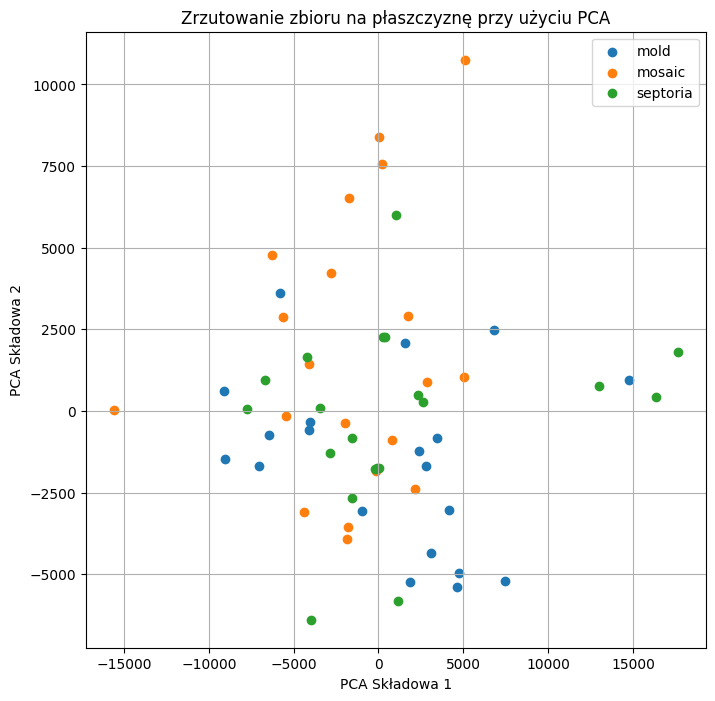

In [20]:
labels = ["mold", "mosaic", "septoria"]
plt.figure(figsize=(8, 8))
for i, label in enumerate(labels):
    plt.scatter(X_pca[i*20:(i+1)*20, 0], X_pca[i*20:(i+1)*20, 1], label=f'Klasa {label}')


plt.title('Zrzutowanie zbioru na płaszczyznę przy użyciu PCA')
plt.xlabel('PCA Składowa 1')
plt.ylabel('PCA Składowa 2')
plt.legend(labels)
plt.grid(True)
plt.savefig("graphs/pca_2d.png")


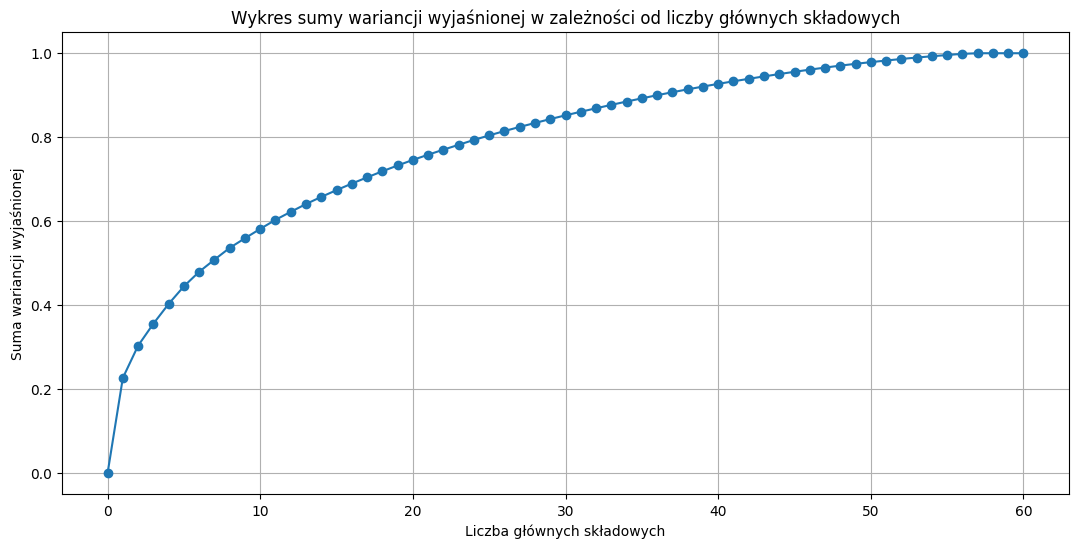

In [21]:
explained_variance_sum = []
for n in range(0, 61):
    explained_variance_sum.append(np.sum(pca.explained_variance_ratio_[:n]))
plt.figure(figsize=(13, 6))
plt.plot(np.arange(0, 61), explained_variance_sum, marker='o', linestyle='-')
plt.title('Wykres sumy wariancji wyjaśnionej w zależności od liczby głównych składowych')
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Suma wariancji wyjaśnionej')
plt.grid(True)
plt.savefig("graphs/var_sum.png")


### Macierz Kowariancji

In [22]:
print(f"Wymiary macierzy kowariancji przed PCA: {len(X.T)}x{len(X.T)}")
print(f"Wymiary macierzy kowariancji przed PCA: {len(X_pca.T)}x{len(X_pca.T)}")

Wymiary macierzy kowariancji przed PCA: 50176x50176
Wymiary macierzy kowariancji przed PCA: 60x60


## Średnie zdjęcie odjęte od pozostałych

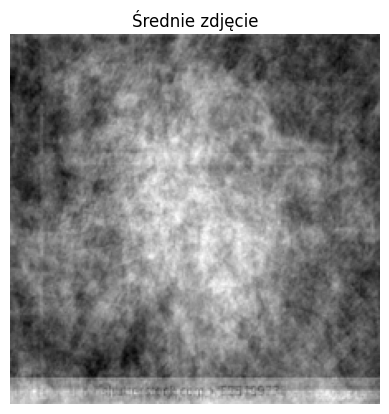

In [23]:
average_image_reshaped = average_image.reshape(224, 224)
plt.imshow(average_image_reshaped, cmap='gray')
plt.axis('off')
plt.title('Średnie zdjęcie')
plt.show()

## Nowe wektory bazowe

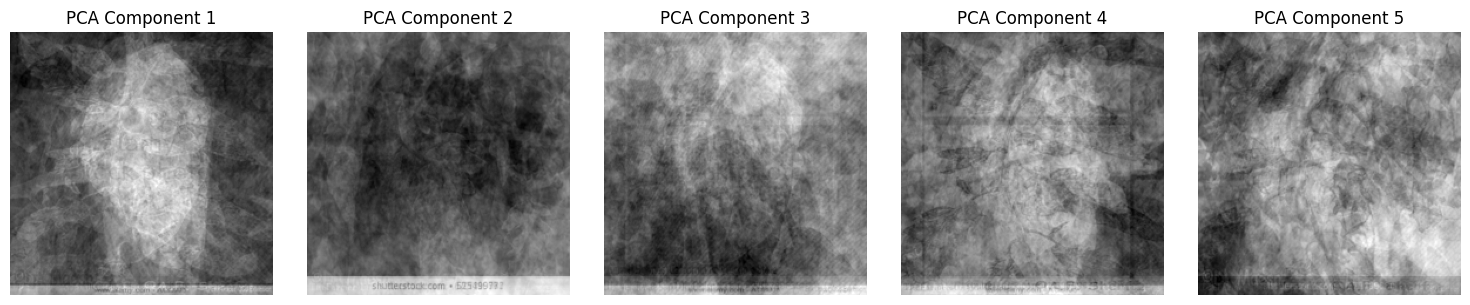

In [24]:
# znalezienie nowych wektorów bazowych

principal_axes = pca.components_
explained_variance = pca.explained_variance_

# Sortowanie według powiązanej wariancji
sorted_indices = np.argsort(explained_variance)[::-1]
principal_axes = principal_axes[sorted_indices]
explained_variance = explained_variance[sorted_indices]

# wizualizacja
num_images= 5

fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    ax = axes[i]
    principal_axis_reshaped = principal_axes[i].reshape(224, 224)
    ax.imshow(principal_axis_reshaped, cmap='gray')
    ax.axis('off')
    ax.set_title(f"PCA Component {i+1}")

plt.tight_layout()
plt.show()

## Redukcja wymiarowości obserwacji

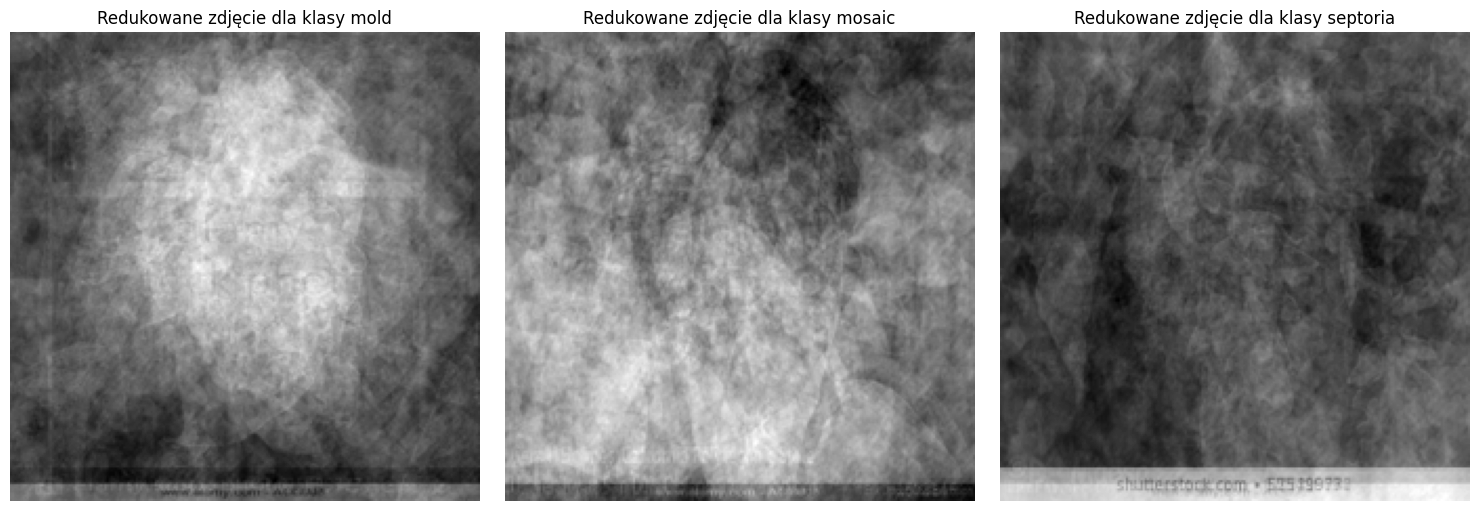

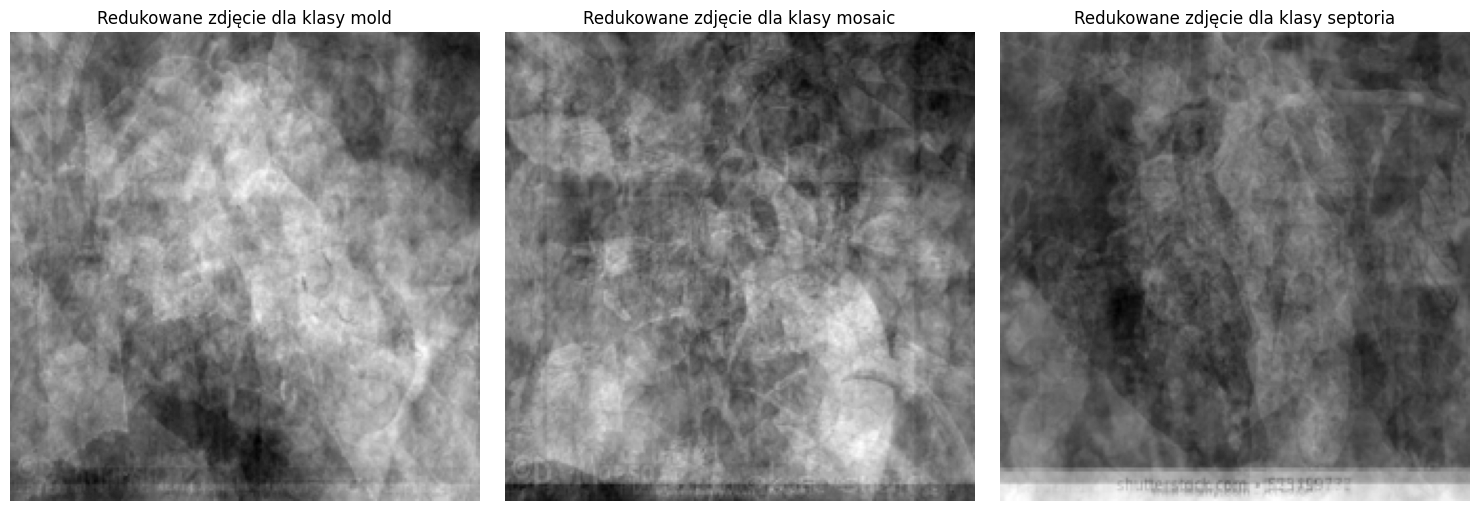

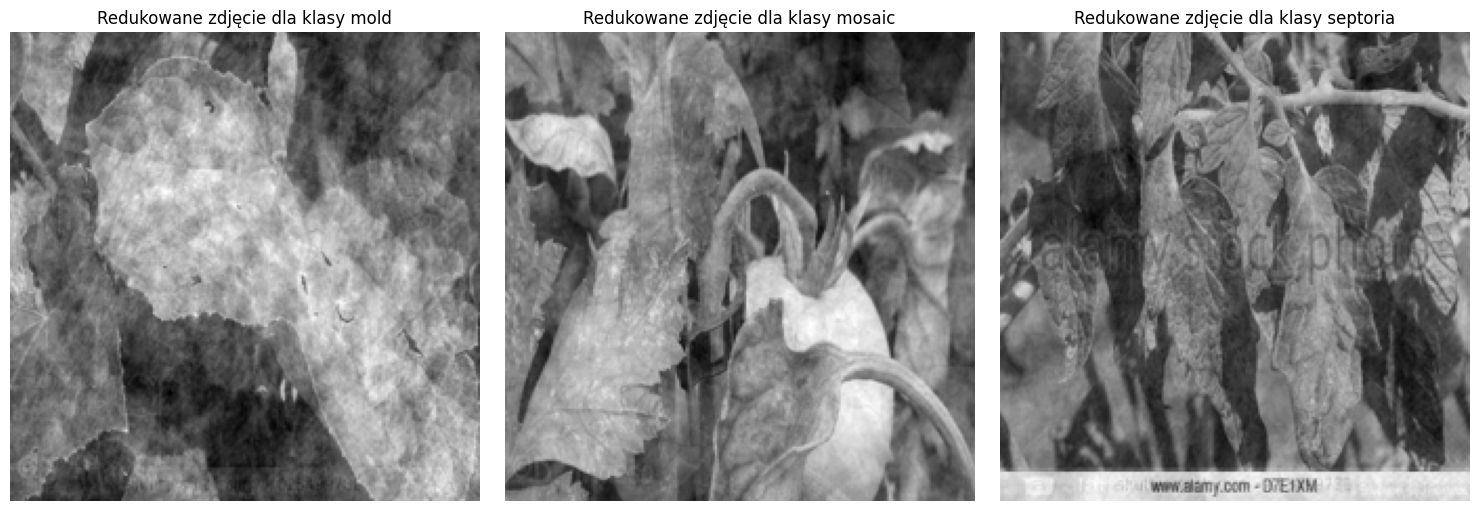

In [25]:
num_components = [3, 9, 27]
i = 0
X_reduced_arr = []

for n in num_components:
    
    # Wybierz n najważniejszych składowych
    pca_components_subset = principal_axes[:n, :]

    # Przeprowadź transformację odwrotną
    X_reduced = np.dot(X_pca[:, :n], pca_components_subset)

    # Dodaj średni wektor
    X_reduced = X_reduced + average_image

    # Przekształć wektory do kształtu zdjęcia i wyświetl
    fig, axes = plt.subplots(1, len(data_folders), figsize=(15, 5))

    for i, ax in enumerate(axes):
        # Odwróć przekształcenie wektor->macierz
        img_reduced = X_reduced[i * 20].reshape(224, 224)

        ax.imshow(img_reduced, cmap='gray')
        ax.set_title(f'Redukowane zdjęcie dla klasy {data_folders[i]}')
        ax.axis('off')
    X_reduced_arr.append(X_reduced)
    plt.tight_layout()
    plt.show()
